In [1]:
import torch, torchvision, PIL, cv2
import warnings 
warnings.filterwarnings('ignore')

from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn

/home/user1/바탕화면/yes/envs/test/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Device : {device}")

Device : cuda


In [3]:
# model_path 불러오기
m_path1 = f"C:/Users/PC00/Desktop/HJ/AICOSS_2023(Pnuemonia)/ResNet.pt"
m_path2 = f"C:/Users/PC00/Desktop/HJ/AICOSS_2023(Pnuemonia)/VGG16.pt"
m_path3 = f"C:/Users/PC00/Desktop/HJ/AICOSS_2023(Pnuemonia)/Effi_Net.pt"

(-0.5, 1437.5, 1259.5, -0.5)

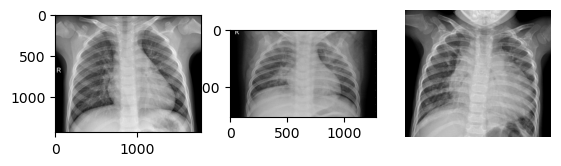

In [4]:
# NORMAL vs VIRUS vs BACTERIA (진단 별 사진 확인)
img_path1 = f"C:/Users/PC00/Desktop/HJ/AICOSS_2023(Pnuemonia)/chest_xray/test/NORMAL/NORMAL2-IM-0353-0001.jpeg"
img_path2 = f"C:/Users/PC00/Desktop/HJ/AICOSS_2023(Pnuemonia)/chest_xray/test/VIRUS/person50_virus_102.jpeg"
img_path3 = f"C:/Users/PC00/Desktop/HJ/AICOSS_2023(Pnuemonia)/chest_xray/test/BACTERIA/person108_bacteria_511.jpeg"
test1 = cv2.imread(img_path1)
test2 = cv2.imread(img_path2)
test3 = cv2.imread(img_path3)
plt.subplot(1,3,1), plt.imshow(test1)
plt.subplot(1,3,2), plt.imshow(test2)
plt.subplot(1,3,3), plt.imshow(test3)
plt.axis('off')

In [5]:
# Image상 불필요한 Noise 제거를 위한 Crop
def crop(img):
    dimension = len(img.shape)
    
    if dimension == 2:
        h,w = img.shape
    else:
        h,w,_ = img.shape
    
    crop_h = int(0.9 * h)
    crop_w = int(0.9 * w)
    
    if dimension == 2:
        cropped_image = img[h-crop_h : crop_h, w-crop_w : crop_w]
    else:
        cropped_image = img[h-crop_h : crop_h, w-crop_w : crop_w, :]
    
    return cropped_image

# Histogram Equalization을 포함한 전처리
def transform(img):
    R = cv2.equalizeHist(img[:, :, 0])
    G = cv2.equalizeHist(img[:, :, 1])
    B = cv2.equalizeHist(img[:, :, 2])
    img = PIL.Image.fromarray(cv2.merge((R, G, B)))

    transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((224, 224)),
    torchvision.transforms.ToTensor()])

    img = transform(img)

    return img

In [6]:
cropped1 = crop(test1)
cropped2 = crop(test2)
cropped3 = crop(test3)

img1 = transform(cropped1)
img2 = transform(cropped2)
img3 = transform(cropped3)

plt.subplot(1,3,1), plt.imshow(img1)
plt.subplot(1,3,2), plt.imshow(img2)
plt.subplot(1,3,3), plt.imshow(img3)
plt.axis('off')

In [7]:
import timm

class Model1(nn.Module):
    def __init__(self, classes=3):
        super().__init__()
        self.model = timm.create_model('resnet50', pretrained=True)
        self.model.fc = nn.Linear(in_features=2048, out_features=classes, bias=True)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        x = self.model(x)
        x = self.softmax(x)

        return x
    
class Model2(nn.Module):
    def __init__(self, classes=3):
        super().__init__()
        self.model = timm.create_model('inception_v4', pretrained=True)
        self.model.last_linear = nn.Linear(in_features=1536, out_features=classes, bias=True)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        x = self.model(x)
        x = self.softmax(x)

        return x
    
class Model3(nn.Module):
    def __init__(self, classes=3):
        super().__init__()
        self.model = timm.create_model('efficientnet_b0', pretrained=True)
        self.model.last_linear = nn.Linear(in_features=1536, out_features=classes, bias=True)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        x = self.model(x)
        x = self.softmax(x)

        return x

In [8]:
model1 = Model1()
model1 = nn.DataParallel(model1).to(device)
model2 = Model2()
model2 = nn.DataParallel(model2).to(device)
model3 = Model3()
model3 = nn.DataParallel(model3).to(device)

In [9]:
def ensemble_test(img, model1, model2, model_path1, model_path2, model_path3):
    model1.load_state_dict(torch.load(model_path1))
    model2.load_state_dict(torch.load(model_path2))
    model3.load_state_dict(torch.load(model_path3))
    model1.eval()
    model2.eval()
    model3.eval()

    img = img.to(device).float()
    
    output1 = model1(img.unsqueeze(0))
    output2 = model2(img.unsqueeze(0))
    output3 = model3(img.unsqueeze(0))
    output = (output1 + output2 + output3)/3

    return output

In [10]:
output1 = ensemble_test(img1, model1, model2, m_path1, m_path2)  # NORMAL image

In [11]:
output2 = ensemble_test(img2, model1, model2, m_path1, m_path2)  # VIRUS image

In [12]:
output3 = ensemble_test(img3, model1, model2, m_path1, m_path2)  # BACTERIA image

In [13]:
print(f"Normal 이미지에 대한 예측값:\n{output1.tolist()}'\n\n")
print(f"Virus 이미지에 대한 예측값:\n{output2.tolist()}'\n\n")
print(f"Bacteria 이미지에 대한 예측값:\n{output3.tolist()}")

Normal 이미지에 대한 예측값:
[[0.4855755567550659, 0.007431075442582369, 0.5069934129714966]]'


Virus 이미지에 대한 예측값:
[[0.0008065050933510065, 0.8387091159820557, 0.1604844331741333]]'


Bacteria 이미지에 대한 예측값:
[[0.014669457450509071, 0.005084147211164236, 0.980246365070343]]
